# Direct Linear Transformation 


$q_i$ = ***P****$Q_i$

\begin{gather}
 \begin{bmatrix} \ sx \\ \ sy \\ s  \end{bmatrix}
 =
 P
  \begin{bmatrix}
   \ X_{i} \\ Y_{i} \\ Z_{i}
   \end{bmatrix}
\end{gather}

P = K*[R t]

\begin{gather}
K
= 
   \begin{bmatrix}
   \ f &  0 & δ_{x} \\ 0 & f & δ_{y} \\ 0 & 0 & 1\
   \end{bmatrix}
\end{gather}

In [34]:
import numpy as np 
import matplotlib.pyplot as plt 
import cv2
import sfunc as sf
from itertools import product
from scipy.spatial.transform import Rotation

In [35]:
theta = 1/np.sqrt(2)
f = 1000 
dx = 1920/2
dy = 1080/2
R = np.matrix([[theta, -theta, 0],[theta, theta, 0],[0, 0, 1]])
t = np.array([[0],[0],[10]])
K = np.matrix([[f, 0, dx],[0, f, dy], [0, 0, 1]])

In [36]:
Rt = np.concatenate((R, t), axis=1)

In [37]:
P = K@Rt
print(P)

[[ 7.07106781e+02 -7.07106781e+02  9.60000000e+02  9.60000000e+03]
 [ 7.07106781e+02  7.07106781e+02  5.40000000e+02  5.40000000e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  1.00000000e+01]]


## Find all the projections of $Q_{xyz}$
$q_{001}$
<br>
$q_{010}$<br>
$q_{100}$<br>
$q_{101}$

In [38]:
Q000 = np.array([[0], [0], [0], [1]])

cartesian product: [0, 1], repeat = 3 -->

[0, 1] * [0, 1] * [0, 1]

[00, 01, 10, 11]*[0, 1]

[000, 010, 100, 110, 001, 011, 101, 111]

In [39]:
Qnh = np.array([list(i) for i in product([0, 1], repeat=3)])
Qnh

array([[0, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 1],
       [1, 0, 0],
       [1, 0, 1],
       [1, 1, 0],
       [1, 1, 1]])

In [40]:
q3,q2,Pm = sf.projectpoints(K, R, t, Qnh)
print(q2.T)

[[ 960.          540.        ]
 [ 960.          540.        ]
 [ 889.28932188  610.71067812]
 [ 895.71756535  604.28243465]
 [1030.71067812  610.71067812]
 [1024.28243465  604.28243465]
 [ 960.          681.42135624]
 [ 960.          668.56486931]]


In [41]:
def crossOp(v):
    """
    v: Vector. The dimensions doesn't matter. Must be a 3d vector
    Cv : It's the cross operation between the vector and itself. It follows the skew-symmetric matrix form 
    """
#     # Check the vector has appropiate form, we want a (3,) 
#     if v.shape == (3,1):
#         v = np.squeeze(v, axis=1)
#     elif v.shape == (1,3):
#         v = np.squeeze(v, axis=0)
#     else:
#         pass
    Cv = np.matrix(np.array([[0, -v[2], v[1]],[v[2], 0, -v[0]], [-v[1], v[0], 0]]))
    return Cv

In [42]:
def squeezdim(v):
    """
    Function that squeezes a vetor into a the form (n,)
    v: vector of dimension n.     
    """
    try:
        m,n = v.shape
    except ValueError:
        return v
    if m>n: 
        v = np.squeeze(v, axis=1)
    else:
        v = np.squeeze(v, axis=0)
    return v

In [43]:
def matrix_B(q, Q):
    """
    Creates a B matrix applying Kroneker product. 
        -1st. Corssproduct on vector q in itslef (qxq):  Uses the approach of a skew symetric matrix.
        -2nd. Krokener product: B = Qi⊗[qi]x
        
    We have to option for estimate B: 
        - Estimate the Homography matrix:
            We want to relate a set of points on 2D with a set of points in 2D. 
            q = [x, y]
            Q = [x, y]
        - Estimate the Projection Matrix:
            We want to calculate the projection matrix given a set of points in 3D and it's projections into a 2D plane 
            q = [x, y]
            Q = [X, Y, Z]
    
    In both cases the points MUST be in Inhomogenous form. 
    """
    
    # Squeez dimesions of q to apply Cross Operation 
    q = squeezdim(q)
    # Transform into homgenous
    q = np.append(q, 1)
    # Create the Skeweness matrix [p1]x
    q = crossOp(q)
    
    # Squeeze vector Q
    Q = squeezdim(Q)
    # Transform into homgenous
    Q = np.append(Q, 1)
    
    # Appply Kroneker Product
    for i in range(len(Q)):
        # Cjeck if the first element it's 0 to create matrix
        if not i:
            B = Q[i] * q
        else:  # If it's not the first element just concatenate the matrices
            B = np.concatenate((B, Q[i]*q),1)
    return B

In [44]:
def projection_matrix(Q, P):
    """
    Given a set of 3D points and it's projections into a 2D plane. We estimate the projection Matrix P.
    It's estimated calculating the B Matrix and solving with singular value decomposition. Where the eigenvector 
    associated with the minimum singular value it's the estimation of the Projection Matrix.
    
    Q: A matrix of q points in homogenous form. where q are the projections into a plane of 3D points. [sx, sy, s]
    Q -> (3,n)
    P: A matrix of p points. Where P are 3D points of the form [X, Y, Z] or [X, Y, Z, 1]
    P-> (3,n), (4,n)
    PrM: An estimation of the projection matrix.
    
    """
    # Transform into arrays
    Q = np.array(Q)
    P = np.array(P)
    # Check if Q it's only one point or a matrix. 
    try:
        mq,nq = Q.shape # We want (3,n). 
        if mq != 3:  # The dimensions are switched. Could be (1,3), (8,3)
            Q = Q.T
            mq,_ = Q.shape 
            if mq != 3:
                print('The vector q Must be in Homogenous form: [sx, sy, s], and it is: ')
                print(Q)
                return False
        elif mq == nq:  # (3,3) We can't know which is the direction 
            print('Make sure that the rows of the matrix are the axis, i.e., (3,n). Being n the number of points')
            print(Q)
        else:
            pass
    except ValueError:
        # Check if the point it's on the form of [sx, sy, s]
        mq, = Q.shape
        if mq != 3:
            # The array doesn't have 3 dimensions. 
            raise ValueError('The vector q Must be in Homogenous form: [sx, sy, s], and it is: ', Q)
        else:
            # # The array has dimensions (3,). correct, add one dim so (3,1)
            Q = np.expand_dims(Q, axis = 1)
            
        
    # Check if P it's only one point or a matrix. 
    try:
        m_p,n_p = P.shape # We want (3,n) or (4,n)
        if m_p != 3 and m_p != 4:  # The dimensions are switched. Could be (1,3), (8,3), (1,4), (8,4)
            P = P.T
            m_p,_ = P.shape 
            if m_p != 3 and m_p != 4: 
                # Check the matix has the appropiate dimensions 
                print('The vector p Must be in Homogenous or Inhomogoenous fom: [X,Y,Z] or [X,Y,Z,1], and it is: ')
                print(P)
                return False
        elif m_p == n_p:  # (3,3) or (4,4) We can't know which is the direction 
            print('Make sure that the rows of the matrix are the axis, i.e., (3,n) or (4,n). Being n the number of points')
            print(P)
        else:
        # The matix has the appropiate dimensions
            pass
    except ValueError:
        # Check if the point it's on the form of [sx, sy, s]
        m_p, = P.shape
        if m_p != 3 and m_p != 4:
            # The array doesn't have 3 dimensions. 
            raise ValueError('The vector q Must be in Homogenous form: [sx, sy, s], and it is: ', P)
        else:
            # The array has dimensions (3,) or (4,1). correct, add one di so (3,1) or (4,1)
            P = np.expand_dims(P, axis = 1)

    
    # Check that both matrices have the same number of points 
    if Q.shape[1] != P.shape[1]:
        print('Not the same amount of points Q has: ', Q.shape, 'and P: ', P.shape)
        return False 
    
    # Create Matrix B
    # p⊗[q]_x (3,1) or (4,1)
    _,n = P.shape
    for i in range(n):
        # check if it's the first time we call the function 
        if not i:
            B = matrix_B(Q[:,i],P[:,i])
        else:
            B = np.concatenate([B, matrix_B(Q[:,i], P[:,i])])
    
    # Apply singular value decomposition 
    scores, s, eigV = np.linalg.svd(B)
    # Find the min eigenvalue, eigenvalue = s**2, min(s) = min (eigenValue)
    idx = np.where(s==min(s))
    
    PrM = eigV[idx].reshape((3,4),order='F')
    PrM = PrM/PrM[-1,-1]

    return PrM

In [45]:
P = projection_matrix(q3, Qnh)
print(P)

[[ 7.07106781e+01 -7.07106781e+01  9.60000000e+01  9.60000000e+02]
 [ 7.07106781e+01  7.07106781e+01  5.40000000e+01  5.40000000e+02]
 [-1.20677247e-13  2.91128608e-13  1.00000000e-01  1.00000000e+00]]


#### Reproject the point Qnh with the estimated Projection Matrix.
Calulate the reprojection error. <br>
E = $\sqrt{\sum||q_{est} − q||^2}$? Does normalizing your points change the results?

In [46]:
def rmserror(qest, q):
    """
    qest it's the esyimated points q. The ones we wish to compare to the originals. 
    qest: 2D points in homogenous or inhonogenous form [sx, sy, s]
    q: set of points in homogenous or inhomogenous form [sx, sy, s] 

    
    qest and q must be in the same from. Homogenous or inohomgenous form 
    """
    # Transform into arryas 
    qest = np.array(qest)
    q = np.array(q)
    if qest.shape != q.shape:
        print("The dimensions of the matrices don't match, make sure that they are in homgogenous form or inhomogenous")
        print('qest shape: ', qest.shape)
        print('q shape: ', q.shape)
        return False
    
    e = np.sqrt(sum(np.sum((qest-q)**2,1)))
    return e

In [47]:
# Transform Qnh into homogenous form (4,n)
Qh = np.vstack([Qnh.T, np.ones(Qnh.T.shape[1])])
# Reproject the Qh points 
qest = np.array(P@Qh)
qest.T

array([[9.60000000e+02, 5.40000000e+02, 1.00000000e+00],
       [1.05600000e+03, 5.94000000e+02, 1.10000000e+00],
       [8.89289322e+02, 6.10710678e+02, 1.00000000e+00],
       [9.85289322e+02, 6.64710678e+02, 1.10000000e+00],
       [1.03071068e+03, 6.10710678e+02, 1.00000000e+00],
       [1.12671068e+03, 6.64710678e+02, 1.10000000e+00],
       [9.60000000e+02, 6.81421356e+02, 1.00000000e+00],
       [1.05600000e+03, 7.35421356e+02, 1.10000000e+00]])

#### The estimated q is in homogenus form [sx, sy, s], we want them in Inhomogenous form [x, y]. We have to divide it by it's scale

In [48]:
# Scale
s = qest[-1,:]
# Divide 
q2est = (qest/s)[:-1,:]  # (2,n)
# Estimate the error with euclidean distance 
e = rmserror(q2est, q2)
print('The error is of the non normalized projections: ', round(e,10))

The error is of the non normalized projections:  6e-10


### Normalize the points to see if there is any differnece in the accuracy

In [49]:
def normalize(P, scale:int=None, points:int=None):
    """
    Given a set of points, Estimates the T matrix which standarizes these points. The given points have to be InHomogenous 
    form and in the form of (dims, points). 
    Being dims the dimensions of the point its given. 2D points = 2, 3D points = 3.
    It follows the following equation:
    
    z = (x-mu_x)/std_x
    
    Can work with all dimensions.
    """
    m,n = P.shape
    if m != 3 and m != 2:
        print('Check the dimensions of your set of points. It should be in inhomogenous form, 2D or 3D points. \nThis is'
              '[sx, sy, z] or [X, Y, Z], which means shapes (2,n) or (3,n). \nThe shape of the given set of points is: \n',
             P.shape)
        return False 
    # calculate the means and unpack them in lists
    *mus, = np.mean(P, axis=1)
    *std, = np.std(P, axis=1)
    # Transform lists into arryas so we can operate with them 
    mus = np.array(mus)
    std = np.array(std)
    # Create the T matrix
    T = np.column_stack([np.diag(1/std),-mus/std])
    # If we want to perserve the scale:
    if scale:
        f = np.zeros((T.shape[1]))
        f[-1] = 1
        T = np.vstack((T,f))
    if points:
        # (3,n)
        points = T@np.vstack((P,np.ones((P.shape[1]))))
        return points, T
    return T

1st. Normalize **Q**, and calculate the projection **q** normalized with the given projection matrix P. <br>
2nd. Once we have both sets of points normalized, estimate again the projection matrix **P**, this time it's normalized. <br>
3th. Calculate the Error.

In [50]:
# Normalize 3D points
Qnh_norm, T = normalize(Qnh.T, points=True)
# Calculate the projections into the 2D Plane
q3norm, q2norm, _  = sf.projectpoints(K,R,t,Qnh_norm)
# Estimate the projection Matrix P 
Pnorm = projection_matrix(q3norm, Qnh_norm)
# Estimate the q points with the estimated Projection Matrix P. Q has to be in homogenous form 
qnormest = P@np.vstack([Qnh_norm, np.ones(8)])
# Obtain the inhomogenous form 
s = qnormest[-1,:]
q2normest = (qnormest/s)[:-1,:]
# Calculate the euclidean error 
Enorm = rmserror(q2normest, q2norm)
print('Error of the normalized projection', Enorm)

Error of the normalized projection 9.361652341497794e-10


## Checkboard Calibration

$$ Q_{ij} = \begin{bmatrix} i-\frac{n-1}{2} \\ j-\frac{m-1}{2} \\ 0 \end{bmatrix},$$

where $i = 0,...,n−1$ and $j = 0,...,m−1$. The points should be returned as a 3xn·m matrix and their order does not matter. These points lie in the z = 0 plane by definition.


In [51]:
def checkerboard_points(n,m):
    """ 
    Given two numbers, n and m. Creates a matrix Q_ij = [i-(n-1)/2, j-(n-1)/2, 0]. 
    Where i=1...n-1 and j=1...m-1.
    Creates all the possible combinations on the range of n and m
    n = 2, m= 2 --> Q = [Q_00, Q_01, Q_10, Q_11]
    
    Returns a matrix of dimensions (3,n*m)
    """
    # Create a function that calculates the value inside one matrix i-(i-1)/2
    val = lambda x,n: x-(n-1)/2
    # specify ranges 
    
    # Create the matrix
    
    M = np.array([np.array([val(i[0],n), val(i[1],m), 0]) for i in product(range(0, n),range(0,m))]).T
    
    return M

In [52]:
Qo = checkerboard_points(10, 20)
Qo.T

array([[-4.5, -9.5,  0. ],
       [-4.5, -8.5,  0. ],
       [-4.5, -7.5,  0. ],
       [-4.5, -6.5,  0. ],
       [-4.5, -5.5,  0. ],
       [-4.5, -4.5,  0. ],
       [-4.5, -3.5,  0. ],
       [-4.5, -2.5,  0. ],
       [-4.5, -1.5,  0. ],
       [-4.5, -0.5,  0. ],
       [-4.5,  0.5,  0. ],
       [-4.5,  1.5,  0. ],
       [-4.5,  2.5,  0. ],
       [-4.5,  3.5,  0. ],
       [-4.5,  4.5,  0. ],
       [-4.5,  5.5,  0. ],
       [-4.5,  6.5,  0. ],
       [-4.5,  7.5,  0. ],
       [-4.5,  8.5,  0. ],
       [-4.5,  9.5,  0. ],
       [-3.5, -9.5,  0. ],
       [-3.5, -8.5,  0. ],
       [-3.5, -7.5,  0. ],
       [-3.5, -6.5,  0. ],
       [-3.5, -5.5,  0. ],
       [-3.5, -4.5,  0. ],
       [-3.5, -3.5,  0. ],
       [-3.5, -2.5,  0. ],
       [-3.5, -1.5,  0. ],
       [-3.5, -0.5,  0. ],
       [-3.5,  0.5,  0. ],
       [-3.5,  1.5,  0. ],
       [-3.5,  2.5,  0. ],
       [-3.5,  3.5,  0. ],
       [-3.5,  4.5,  0. ],
       [-3.5,  5.5,  0. ],
       [-3.5,  6.5,  0. ],
 

Let $Q_\Omega$ define a set of corners on a checkerboard. Then define three sets of checkerboard points $Q_a$, $Q_b$, and $Q_c$, where

$$Q_a= R(\frac{\pi}{10},0,0) Q_\Omega ,$$
$$Q_b= R(0,0,0) Q_\Omega ,$$
$$Q_c= R(-\frac{\pi}{10},0,0) Q_\Omega $$
where

$$ R(\theta_x,\theta_y,\theta_z) = \begin{bmatrix} cos(\theta_z) & -sin(\theta_z) & 0 \\ sin(\theta_z) & cos(\theta_z) & 0 \\ 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} cos(\theta_y) & 0 & -sin(\theta_y)\\ 0 & 1 & 0 \\ sin(\theta_y) & 0 & cos(\theta_y) \end{bmatrix} \begin{bmatrix} 1 & 0 & 0\\ 0 & cos(\theta_x) & -sin(\theta_x) \\ 0 & sin(\theta_x) & cos(\theta_x) \end{bmatrix}$$


In [53]:
thetax = np.pi/10
Qa = Rotation.from_euler('xyz', [thetax, 0, 0]).as_matrix()@Qo
Qb = Rotation.from_euler('xyz', [0, 0, 0]).as_matrix()@Qo
Qc = Rotation.from_euler('xyz', [-thetax, 0, 0]).as_matrix()@Qo

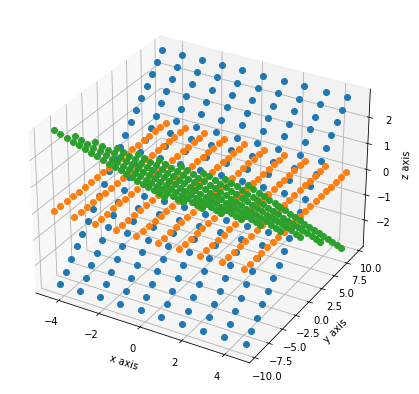

In [54]:
sf.plot3d(Qa, Qb, Qc)

In [55]:
# Transform to homogenous form 
def hom(Q):
    """
    Function that transforms into homogenous form. 
    Q has to be in the form of (2,n) or (3, n)
    Returns the matrix Q but with an extra row of ones
    """
    n = Q.shape[1]
    Q = np.vstack([Q, np.ones(n)])
    return Q

def inhom(Q):
    """
    Return Q in inhomogenous form 
    Given Q divides by the scale:
    [sx, sy, s]/s = [x, y, 1] and we return [x, y]
    In case of a 3D point as the scale is 1 we divide by one and return everything but the last column.
    """
    s = Q[-1,:]
    Q = (Q/s)[:-1,:]
    return Q

qa = P@hom(Qa)
qb = P@hom(Qb)
qc = P@hom(Qc)

qs = [qa, qb, qc]

qa = qa/qa[-1,:]
qa.T
qb = qb/qb[-1,:]

qc = qc/qc[-1,:]



Define a function `estimateHomographies(Q_omega, qs)` which takes the following input arguments:

  - $Q_\Omega$: an array original un-transformed checkerboard points in 3D, for example $Q_\Omega$.
  - $q_s$: a list of arrays, each element in the list containing $Q_\Omega$ projected to the image plane from
    different views, for example $q_s$ could be $[q_a,q_b,q_c].$
 
 
 
The function should return the homographies that map from $Q_\Omega$ to each of the entries in $q_s$.

The homographies should work as follows:
$$q= H Q'_\Omega$$

where $Q'_\Omega$ is $Q_\Omega$ without the z-coordinate, in homogeneous coordinates. Remember that we need
multiple orientations of checkerboards e.g. rotated and translated.

Use your function `hest` from week 2 to estimate the individual homographies. Your should return a list of homographies; one homography for each checkerboard orientation.
Test your function using $Q_\Omega$, $q_a$, $q_b$, and $q_c$. 

In [56]:
def estimateHomographies(Q_omega, *args):
    """
    The function should return the homographies that map from  𝑄Ω  to each of the entries in  𝑞𝑠.
    
    𝑄Ω : An array original un-transformed checkerboard points in 3D, for example 𝑄Ω. (3,n). 
         Being n the number of points 
    
    𝑞𝑠: A list of arrays, each element in the list containing 𝑄Ω projected to the image plane from different views,
        For example 𝑞𝑠 could be [𝑞𝑎,𝑞𝑏,𝑞𝑐,...𝑞z]. (3,n) of length m. 
        Being "n" the number of points and "m" the number of different views.
        
    """
    # Check dimension of Q_omega
    if Q_omega.shape[0] != 3:
        print("Please insert the matrix Q_omega in the form of (3,n)")
        return
    Q_omega = Q_omega[:-1,:]
    
#     n = len(args)
#     H = np.zeros((3,3,n))
    H = []
    for q in args:
        # check dimensions 
        if q.shape[0] == 3:
            q = q[:-1,:]
        elif q.shape[0] == 2:
            pass
        else:
            print('Please make sure the qs are in the form of (dimensions, number_of_points)')
            return 
        # Estimate H     
        H.append(sf.hest(q, Q_omega))
        
        
    return H

In [57]:
Hs = estimateHomographies(Qo, qa, qb, qc)
Ha_est = Hs[0]
Hb_est = Hs[1]
Hc_est = Hs[2]
print(Ha_est)
print(Hb_est)
print(Hc_est)

[[ 7.07106781e+01 -3.75842197e+01  9.60000000e+02]
 [ 7.07106781e+01  8.39367689e+01  5.40000000e+02]
 [ 4.42946383e-14  3.09016994e-02  1.00000000e+00]]
[[ 7.07106781e+01 -7.07106781e+01  9.60000000e+02]
 [ 7.07106781e+01  7.07106781e+01  5.40000000e+02]
 [-1.49427001e-13  3.29241736e-13  1.00000000e+00]]
[[ 7.07106781e+01 -9.69154827e+01  9.60000000e+02]
 [ 7.07106781e+01  5.05629335e+01  5.40000000e+02]
 [-1.53054878e-13 -3.09016994e-02  1.00000000e+00]]


To check if the Estimated homographies are correct, we are going to estimate the projected points into the 2D plane
$$q= H Q'_\Omega$$

where $Q'_\Omega$ is $Q_\Omega$ without the z-coordinate, in homogeneous coordinates. [X, Y, 1]

In [58]:
# Drop the last dimension 
Qo_ti = Qo[:-1,:]
# Add ones
Qo_ti = hom(Qo_ti)
# Estimate 
qa_est = Ha_est@Qo_ti
qb_est = Hb_est@Qo_ti
qc_est = Hc_est@Qo_ti

In [59]:
# Check the points
qa_est = qa_est/qa_est[-1,:]
qb_est = qb_est/qb_est[-1,:]
qc_est = qc_est/qc_est[-1,:]
idxa = np.random.randint(200)
idxb = np.random.randint(200)
idxc = np.random.randint(200)
print('Point on qa_est')
print(qa_est[:,idxa].T)
print('Point on qa')
print(qa[:,idxa].T)
print('\nPoint on qb_est')
print(qb_est[:,idxb].T)
print('Point on qb')
print(qb[:,idxb].T)
print('\nPoint on qc_est')
print(qc_est[:,idxc].T)
print('Point on qc')
print(qc[:,idxc].T)



Point on qa_est
[[5.35288274e+02 1.02071289e+03 1.00000000e+00]]
Point on qa
[[5.35288274e+02 1.02071289e+03 1.00000000e+00]]

Point on qb_est
[[1.10142136e+03 4.69289322e+02 1.00000000e+00]]
Point on qb
[[1.10142136e+03 4.69289322e+02 1.00000000e+00]]

Point on qc_est
[[1.2929300e+03 6.8011778e+02 1.0000000e+00]]
Point on qc
[[1.2929300e+03 6.8011778e+02 1.0000000e+00]]


### Solving Camera Calibration 
Zhang Zhengyou: Closed form solution 

\begin{gather}
 B = A^{-T} * A^{-1} = 
  \begin{bmatrix}
   \ B_{11} & B_{12} & B_{13} \\
   \ B_{21} & B_{22} & B_{23} \\
   \ B_{31} & B_{32} & B_{33} 
   \end{bmatrix}
\end{gather}

The matrix is symetric, so we only need to describe the upper diagonal 

\begin{gather}
 b  = 
  \begin{bmatrix}
   \ B_{11} & B_{12} & B_{22} & B_{13} & B_{23} & B_{33} 
   \end{bmatrix}^T
\end{gather}

Let the $i^{th}$ column vector of H be: 
\begin{gather}
 h_i = 
 \begin{bmatrix}
   \ h_{i1} & h_{i2} & h_{i3} 
   \end{bmatrix}^T
\end{gather}

\begin{gather}
 h_j = 
 \begin{bmatrix}
   \ h_{j1} & h_{j2} & h_{j3} 
   \end{bmatrix}^T
\end{gather}
Then:

$h_i^T * B * h_j = v_{ij}^T *b$

Where: 
\begin{gather}
 v_{ij} = 
 \begin{bmatrix}
 \ (h_{i1}*h_{j1}) & (h_{i1}*h_{j2} +  h_{i2}*h_{j1}) & (h_{i2}*h_{j2}) & (h_{i3}*h_{j1} + h_{i1}*h_{j3}) & (h_{i3}*h_{j2} +     h_{i2}*h_{j3})  & (h_{i3}*h_{j3})
 \end{bmatrix}^T
\end{gather}

In [60]:
a = [4, 5, 6]
b = [3, 2, 1]
build_v(a,b)

array([12, 23, 10, 22, 17, 6], dtype=object)

In [61]:
def build_v(hi, hj):
    """
    Creates a vector v from 2 column vectors.
     vij = [(h_{i1}*h_{j1}), (h_{i1}*h_{j2} + h_{i2}*h_{j1}), (h_{i2}*h_{j2}), (h_{i3}*h_{j1} + h_{i1}*h_{j3}),
     (h_{i3}*h_{j2} + h_{i2}*h_{j3}), (h_{i3}*h_{j3})]
    """
    # Create the vector vij
    v = np.array([None]*6)
    
    # Transform and squeez 
    hi = squeezdim(np.array(hi))
    hj = squeezdim(np.array(hj))
    
    v[0],v[2],v[5] = hi * hj 
    v[1],v[3] = hi[0]*hj[1:] + hj[0]*hi[1:]
    v[4] = hi[2]*hj[1] + hi[1]*hj[2]
    
    return v    

In [62]:
def build_V(H):
    """
    Check the function build_v
    Function that creates the vectors: v11, v12, v22. Following the expression vij on the function. Where i and j 
    are the columns of H.
    """
    # Generate the vectors 
    v11 = build_v(H[:,0], H[:,0])
    v12 = build_v(H[:,0], H[:,1])
    v22 = build_v(H[:,1], H[:,1])
    
    V_sing = np.array([[*v12],[*(v11-v22)]])
    return V_sing
    

In [63]:
build_V(Hs[0]).T

array([[-2.65760566e+03,  3.58742643e+03],
       [ 3.27762018e+03,  1.63093959e+04],
       [ 5.93522585e+03, -2.04538117e+03],
       [ 2.18508012e+00,  2.32283252e+00],
       [ 2.18508012e+00, -5.18757761e+00],
       [ 1.36877960e-15, -9.54915028e-04]])

In [64]:
def estimate_b(Hs:list):
    """
    Takes a list of homographiy matrices and calculates the matrix V of all those Homography matrices. 
    Then Applies singular value decomposition to estimate b matrix following the euaation:
    V*b = 0 
    """
    # Create an empty matrix of desired dimensions 
    n = len(Hs)
    # Generate the matrix V
    V = np.zeros((2*n,6)) 
    # Choose the steo size
    step = 2
    for i,e in zip(range(0,V.shape[0],step),range(n)):
        V[i:i+step,:] = build_V(Hs[e])
    
    _, s, eigVec = np.linalg.svd(V)
    # Find the min s standard deviation (s**2 ara singular values)
    idx = np.where(s==min(s))
    # Select the eigenvector correspondent to the eigenvalue
    b = eigVec[idx]
# Is b returned in with the same order?
    
    # Transform the vector into a symetric matrix.    
    # Check the transformation, it's not like the upper symetric indexes 
    
    B_dim = 3 # Has to be squared
    B = np.zeros((B_dim,B_dim))
    # Get ideces of upper diagonal matrix
    idx_upp_diag = np.triu_indices(B_dim, k=0) # b contains the offset (diagonal)
    B[idx_upp_diag] = b
    B = B.T + B - np.diag(np.diag(B))
    
    return B, b, V
    

In [65]:
B_est, b, V = estimate_b(Hs)
A = np.zeros((3,3))
A[0,0] = b[0][0]
A[0,1] = b[0][1]
A[1,1] = b[0][2]
A[0,2] = b[0][3]
A[1,2] = b[0][4]
A[2,2] = b[0][5]
A1 = A.T + A - np.diag(np.diag(A))
# A1/A[-1,-1]*B_true[-1,-1]
b

array([[ 4.51834392e-07, -2.70491855e-19,  4.51834392e-07,
        -4.33761016e-04, -2.43990572e-04,  9.99999876e-01]])

In [66]:
B_true = np.linalg.inv(K).T@np.linalg.inv(K)
b_true = np.array([B_true[0,0],B_true[0,1],B_true[1,1],B_true[0,2],B_true[1,2],B_true[2,2]])
B_true
print(b_true)
print(b)

[ 1.0000e-06  0.0000e+00  1.0000e-06 -9.6000e-04 -5.4000e-04  2.2132e+00]
[[ 4.51834392e-07 -2.70491855e-19  4.51834392e-07 -4.33761016e-04
  -2.43990572e-04  9.99999876e-01]]


In [67]:
s = (b_true/b)[0][0]
s

2.2132002740582153

#### Check if 
$v_{11}*b_{true} = h_{1}^T*B_{true}*h_1$

In [68]:
h1 = Hs[0][0,:].T
v11 = np.array([build_v(h1,h1)]).T
b_true = np.expand_dims(b_true, axis=1)

In [69]:
print((v11.T@b_true)[0][0])
print((h1.T*B_true*h1)[0,0])

(v11.T@b_true)[0][0] == (h1.T*B_true*h1)[0,0]

2039593.7598095986
2039593.7598095988


False

In [70]:
print((v11.T@b.T)[0][0]*s)
print((h1.T*A1*h1)[0,0]*s)

2039593.7597865642
2039593.759786564


Estimate the intrinsics of the camera matrix with b

In [71]:
def estimateIntrinsics(Hs):
    """
    Following, A Flexible New Technique for Camera Calibration Paper from Zhengyou Zhang. We calculate the intrinsics 
    parameters of the camera Matrix K (in the paper refered ad A) from the Matrix B.
    We can estimate them as: 
        B = λ*A.T*A
    
    """
    _,b,_ = estimate_b(Hs)
    b = squeezdim(b)
    v0 = (b[1]*b[3]-b[0]*b[4])/(b[0]*b[2]-b[1]**2)
    lamb = b[5]-(b[3]**2+v0*(b[1]*b[3]-b[0]*b[4]))/b[0]
    alpha = np.sqrt(lamb/b[0])
    beta = np.sqrt(lamb*b[0]/(b[0]*b[2]-b[1]**2))
    gamma = -b[1]*alpha**2*beta/lamb
    u0 = gamma*v0/beta - b[3]*alpha**2/lamb
    
    K = np.matrix([[alpha, gamma, u0], [0, beta, v0], [0, 0, 1]])
    return K
    

In [72]:
estimateIntrinsics(Hs)

matrix([[1.00000000e+03, 5.98652649e-10, 9.60000000e+02],
        [0.00000000e+00, 1.00000000e+03, 5.40000000e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [79]:
def estimateExtrinsics(K, Hs):
    """
    Following A Flexible New Technique for Camera Calibration Paper from Zhengyou Zhang. 
    We calculate the extrinsic parameters, i.e., Rotation matrix and translation vector, R and t respectively.
    
    Given a list of homography matrices estimate for each homography the roataion matrices Rs and translation vectors ts.
    For 
    
    """
    # Create empty lists to store the values of the rotation matrix and translation vector
    Rs = []
    ts = []
    K_inv = np.linalg.inv(K)  # (3,3)
    for H in Hs:
        h1 = H[:,0]  # (3,1)
        h2 = H[:,1]  # (3,1)
        h3 = H[:,2]  # (3,1)
        lamb = 1/np.linalg.norm(K_inv@h1)
        r1 = lamb*K_inv@h1
        r2 = lamb*K_inv@h2
        r3 = np.cross(r1.T, r2.T).T
        t = lamb*K_inv@h3
        R = np.concatenate([r1, r2, r3], axis = 1)
        Rs.append(R)
        ts.append(t)
    
    return Rs, ts

In [80]:
Ra = Rotation.from_euler('xyz', [thetax, 0, 0]).as_matrix()
Ra/Ra[-1,-1]

array([[ 1.05146222,  0.        ,  0.        ],
       [ 0.        ,  1.        , -0.3249197 ],
       [ 0.        ,  0.3249197 ,  1.        ]])

In [81]:
Rs[0]/Rs[0][-1,-1]

matrix([[ 7.43496069e-01, -7.07106781e-01,  2.29752921e-01],
        [ 7.43496069e-01,  7.07106781e-01, -2.29752921e-01],
        [ 4.65741389e-13,  3.24919696e-01,  1.00000000e+00]])

In [82]:
Rs, ts = estimateExtrinsics(K, Hs)
Rs

[matrix([[ 7.07106781e-01, -6.72498512e-01,  2.18508012e-01],
         [ 7.07106781e-01,  6.72498512e-01, -2.18508012e-01],
         [ 4.42946383e-13,  3.09016994e-01,  9.51056516e-01]]),
 matrix([[ 7.07106781e-01, -7.07106781e-01,  3.38469910e-12],
         [ 7.07106781e-01,  7.07106781e-01, -1.27148218e-12],
         [-1.49427001e-12,  3.29241736e-12,  1.00000000e+00]]),
 matrix([[ 7.07106781e-01, -6.72498512e-01, -2.18508012e-01],
         [ 7.07106781e-01,  6.72498512e-01,  2.18508012e-01],
         [-1.53054878e-12, -3.09016994e-01,  9.51056516e-01]])]

In [83]:
ts

[matrix([[-2.09610107e-13],
         [-1.11910481e-13],
         [ 1.00000000e+01]]),
 matrix([[-3.85469434e-13],
         [-2.14050999e-13],
         [ 1.00000000e+01]]),
 matrix([[-2.22044605e-13],
         [-1.34114941e-13],
         [ 1.00000000e+01]])]